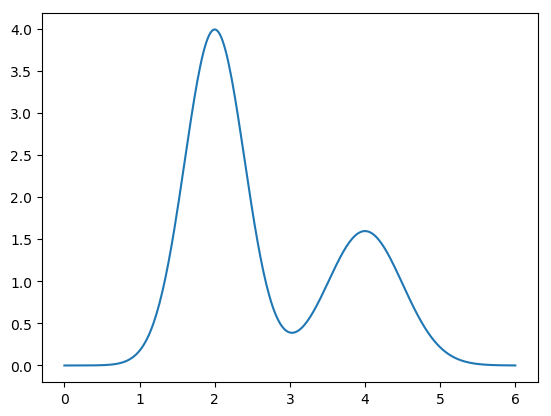

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19ab3f128>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [44]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

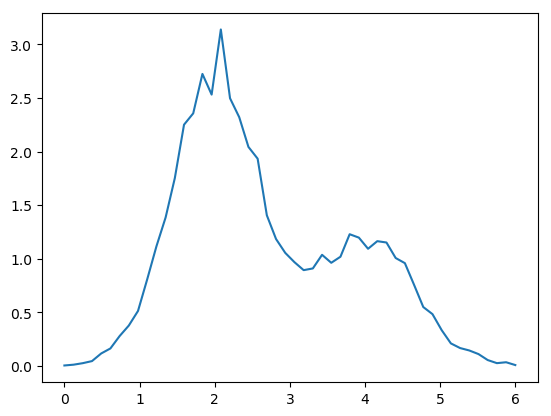

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a48d7d68>

In [45]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

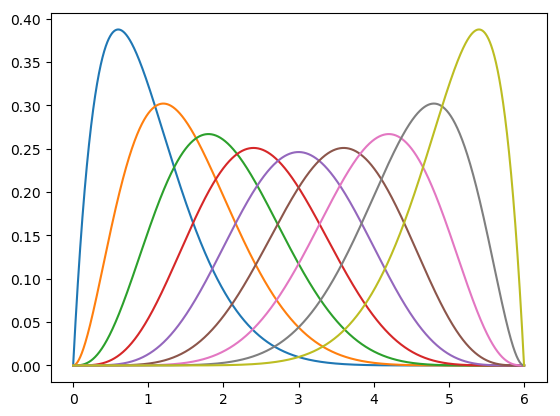

In [46]:
basis = BernsteinBasis(a, b, 10, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end

In [47]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

50×9 Array{Float64,2}:
 0.133245    0.0465937    0.0132908    …  9.40244e-7   5.33705e-8 
 0.172568    0.0667283    0.020774        2.08184e-6   1.25525e-7 
 0.211797    0.090876     0.0309452       4.41833e-6   2.8322e-7  
 0.247248    0.118069     0.0440561       9.00617e-6   6.1421e-7  
 0.275629    0.146832     0.0601202       1.76666e-5   1.28272e-6 
 0.29465     0.175378     0.0788682    …  3.34153e-5   2.58456e-6 
 0.303337    0.201869     0.0997476       6.10596e-5   5.03361e-6 
 0.302       0.224665     0.121965        0.000107992  9.49275e-6 
 0.29194     0.242513     0.144564        0.0001852    1.73652e-5 
 0.275034    0.254643     0.166517        0.000308502  3.08656e-5 
 0.253338    0.26078      0.186824     …  0.000499991  5.33915e-5 
 0.228791    0.261082     0.20459         0.000789647  9.002e-5   
 0.203046    0.256048     0.21909         0.00121706   0.000148151
 ⋮                                     ⋱                          
 9.002e-5    0.000789647  0.00442454   

In [48]:
model = model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[14.4118 14.1912 … 0.0886124 0.0178253; 14.1912 16.8326 … 0.372789 0.0886124; … ; 0.0886124 0.372789 … 16.8326 14.1912; 0.0178253 0.0886124 … 14.1912 14.4118]], 9, "EmpiricalBayes", nothing)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -3.127483e+02     1.756941e+02
     1    -4.868081e+02     8.999999e+00
     2    -7.677517e+02     2.368276e+00
     3    -7.678964e+02     1.979685e+00
     4    -7.681947e+02     4.970698e-02
     5    -7.681949e+02     1.241748e-04
     6    -7.681949e+02     1.266829e-04
     7    -7.681949e+02     4.433588e-04
     8    -7.681949e+02     2.408780e-04
     9    -7.681949e+02     1.803491e-04
    10    -7.681949e+02     5.915405e-04
    11    -7.681949e+02     3.937791e-04
    12    -7.681949e+02     9.299089e-05
    13    -7.681949e+02     2.646119e-04
    14    -7.681949e+02     3.412833e-04
    15    -7.681949e+02     8.826290e-05
    16    -7.681949e+02     2.547163e-04
    17    -7.681949e+02     1.753039e-04
    18    -7.681949e+02     2.142904e-04
    19    -7.681949e+02     1.553723e-04
    20    -7.681949e+02     1.134290e-05
    21

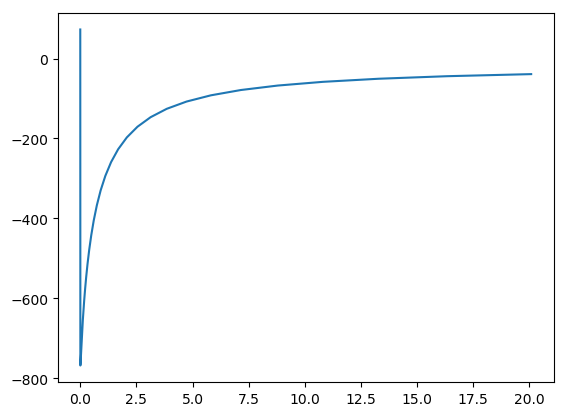

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.00447958]
  "coeff"  => [-0.121707, 9.74556, -64.4679, 183.983, -238.182, 175.942, -70.42…
  "sig"    => [9.35627 -49.5682 … -19.9237 2.79436; -49.5682 277.578 … 139.457 …

In [49]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

In [50]:
phivec = PhiVec(result["coeff"], basis, result["sig"])

PhiVec([-0.121707, 9.74556, -64.4679, 183.983, -238.182, 175.942, -70.4231, 15.8422, -1.51022], BernsteinBasis(0.0, 6.0, Any[BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 1, 10.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 2, 45.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 3, 120.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 4, 210.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 5, 252.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 6, 210.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 7, 120.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 8, 45.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 9, 10.0), (0.0, 6.0))], ("dirichlet", 

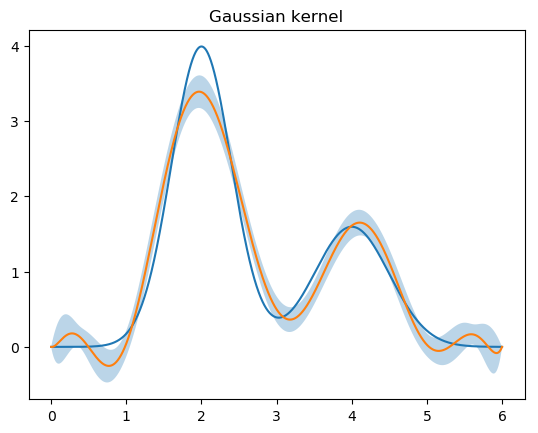

In [51]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
title("Gaussian kernel")
savefig("bernstein_gaussian.png", dpi=1000)

In [19]:
length(basis)

29